# Début d'implémentation du modèle

### Étape 0 : Importations

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import math
import pandas as pd

import time

from random import *
import random
from random import randrange
from random import sample 
random.seed(1)
np.random.seed(1)

from numpy.random import multinomial

### Étape 1 : Créations du corpus

In [2]:
liste_couples = {
    0:("homme","femme"),
    1:("chien","chat"),
    2:("vanille","chocolat"),
    3:("poli","courtois"),
    4:("choqué","horrifié"),
    5:("propre","sale"),
    6:("canapé","fauteuil"),
    7:("téléphone","portable"),
    8:("voiture","camion"),
    9:("grand","petit")
}

couples_contexte = {
("homme","femme") : ["sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],                  
("chien","chat") : ["animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
("vanille","chocolat") : ["parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
("poli","courtois") : ["bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
("choqué","horrifié") : ["peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
("propre","sale") : ["nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
("canapé","fauteuil") : ["maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
("téléphone","portable") : ["appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
("voiture","camion") : ["moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
("grand","petit") : ["taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
}

bruits = ['ALLATES','NEBULES','LONGTON','PAWESIN','SORENGO','SEXTEES','TAXIONS','ELEWIJT','EPEISME','APOTOME',
'REMORVA','HOBOKEN','MALICES','SOMZEEN','NEDDOIS','RECLIVA','GILEREZ','GAULDOS','GOINFRA','RAYERES','BOTTEES','VAGITES','PRELEES','GARDERA','ANATASE','DATASSE',
'BILLAGE','POUCAVE','REFUGES','REDIMAI','SOLANGE','EMBOISE','BACHAGA','FAMINER','ECUMONS','HARWELL','VEURDES','AZURERA','ENUQUAI','MAULAIS','MEVENIR','GAUDENT',
'MENTANA','REHERSE','ARBECEY','FAUXAMI','BALADOU','REVERDI','BEDAVES','BORAMES','PONTIFE','ALESIEZ','REFIXER','IRRUIEZ','DRESSEZ','PYROIDE','GNAQUAI','LAVETON',
'RERESTA','EPRISSE','FROLERA','RAVEURS','CITRINE','NAUNHOF','FEUTRIE','RETASEE','TIMBREE','GANTERA','HALENES','SUSIENS','DEGOUTE','BINAGES','VEAUTES','LAISSAI',
'STERANE','RECERNE','RELIQUE','FLAGGER','DELAVAS','SUADERA','PINIERS','DOMPTER','CARRARE','ROSAZIA','LIMITAS','EUCLIDE','FARCANT','BLATERE','STRICTS','REFLOTS',
'PAGELLE','BLAUZAC','BROCHER','TOPDOWN','UNIFERE','EHOUPER','ASININS','ASSAKIS','HOTELES','DENIOTE']

i = 0
for mot in bruits:
    mot_min = mot.lower()
    bruits[i] = mot_min
    i += 1
    
t_corpus = []
for i in range(10000):
    indiceCouple = randrange(0,10)
    membreCouple = randrange(0,2)
    # On a notre mot clé
    mot_cle = liste_couples[indiceCouple][membreCouple]
    # On récupère les contextes, on va en tirer 5
    liste_mot = couples_contexte[liste_couples[indiceCouple]]
    ech_contexte = sample(liste_mot,5)
    # On génère le bruit 
    ech_bruit = sample(bruits,3)
    # On crée la phrase
    phrase = []
    phrase.append(mot_cle)
    for mot in ech_contexte:
        phrase.append(mot)
    for bruit in ech_bruit:
        phrase.append(bruit)
    random.shuffle(phrase)
    t_corpus.append(phrase)

### Étape 2 : Créer le vocabulaire à partir du corpus de phrases

In [3]:
voc = []
freqs = {}
for phrase in t_corpus:
    for mot in phrase:
        if mot not in voc:
            voc.append(mot)
            freqs[mot] = 1
        else:
            freqs[mot] +=1
voc_size = len(voc)
print(voc_size)

218


### Étape 3 : Calcul des probas pour le subsampling et le negative sampling

In [4]:
total_mots = 0
for phrase in t_corpus:
    total_mots += len(phrase)

In [5]:
for key, value in freqs.items():
    freqs[key] = value / total_mots

In [6]:
# Probabilité d'être gardé dans le subsampling
p_sub = {word: min((math.sqrt(freqs[word]/0.001)+1)*(0.001/freqs[word]),1) for word in freqs}

In [7]:
p_neg_1 = {word: freqs[word]**(3/4) for word in freqs}
total_neg = 0
for word in p_neg_1:
    total_neg+=p_neg_1[word]
p_neg = {word: p_neg_1[word]/total_neg for word in p_neg_1}

In [8]:
def subSampling(phrase):
    phrase_samp = []
    for mot in phrase:
        if np.random.random() < (p_sub[mot]):
                phrase_samp.append(mot)
    return phrase_samp

In [9]:
t_corpus_samp = []
for phrase in t_corpus:
        # Sub-sampling : pour chaque phrase, on réalise le subsampling éventuel.
        phrase_samp = subSampling(phrase)
        if len(phrase_samp)>1:
            t_corpus_samp.append(phrase_samp)

In [10]:
mot_index = {w: index for (index, w) in enumerate(voc)}
index_mot = {index: w for (index, w) in enumerate(voc)}

### Étape 4 : Création du modèle

In [11]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

def live_plot(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.show();

In [12]:
#Couche d'entrée
def get_input_layer(word_idx):
    x = torch.zeros(voc_size).float()
    x[word_idx] = 1.0
    return x

# Choix de dimension
embedding_dims = 10
# Initialisation
# Variable : comme Tensor mais avec les valeurs qui changent pendant le traitement
W1 = Variable(torch.randn(embedding_dims, voc_size).float(), requires_grad=True)
W2 = Variable(torch.randn(voc_size, embedding_dims).float(), requires_grad=True)
num_epochs = 50 # "époques"
learning_rate = 0.01
taille_fenetre = 5
loss_tot = []

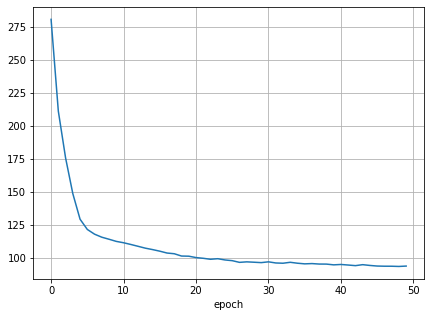

13.05


In [13]:
start = time.time()
# Différentes étapes
for epo in range(num_epochs):
    loss_val = 0
    for phrase in t_corpus_samp:
        # On crée tous les couples par phrase
        index_pairs = []
        indices = [mot_index[mot] for mot in phrase]
        # On traite chaque mot comme un mot central
        for center_word in range(len(indices)):
        # Pour chaque fenetre possible
            for w in range(-taille_fenetre, taille_fenetre + 1):
                context_word = center_word + w
                # On fait attention à ne pas sauter de phrases
                if context_word < 0 or context_word >= len(indices) or center_word == context_word:
                    continue
                context_word_ind = indices[context_word]
                index_pairs.append((indices[center_word], context_word_ind))
        if len(index_pairs) > 0:
            # On en choisit une
            focus, context = choice(index_pairs)

            # Calcul loss 
            
            # Loss du couple OK
            x = Variable(get_input_layer(focus)).float()
            z1 = torch.matmul(W1, x)
            vec_context = W2[context]
            z2 = torch.matmul(vec_context, z1)

            sigmoid = F.logsigmoid(z2)
            loss1 =  -sigmoid
            loss_val += loss1
        
            # Negative samples
            sampled_index = np.array(multinomial(4, list(p_neg.values())))
            word_list = []
            for index, count in enumerate(sampled_index):
                for _ in range(count):
                     word_list.append(index)

            # Loss des negative sample
            
            vec_neg = W2[word_list]
            z2 = torch.matmul(vec_neg, z1)
            sigmoid = F.logsigmoid(-z2)
            loss2 = -sigmoid.sum()
            loss_val += loss2
            
            # Propagation
            (loss1+loss2).backward()
            W1.data -= learning_rate * W1.grad.data
            W2.data -= learning_rate * W2.grad.data

            W1.grad.data.zero_()
            W2.grad.data.zero_()
    loss_tot.append(loss_val / voc_size)
    live_plot(loss_tot)
end = time.time()
print(round((end - start)/60, 2))

#    if epo%10==0:
#        print(f"Loss à l'époque {epo}: {loss_val/voc_size}")
#print(f"Loss à l'époque {num_epochs}: {loss_val/voc_size}")

In [17]:
W3 = (W1.t() + W2)/2

In [18]:
# Sauvegarder les poids - utile si traitement trop long
with open ("mat.txt", "w") as f:
    for i in range (0,len (W3)) :
        for j in range (0, len (W3[i])) :
            f.write ( str (W3[i][j]) + "\t")
        f.write ("\n")
f.close()

In [20]:
W3 = Variable(torch.randn(voc_size, embedding_dims).float(), requires_grad=True)
with open("mat.txt", 'r') as filin:
    lignes = filin.readlines()
    for i in range(0,218):
        val = lignes[i].split("\t")
        for j in range(0,10):
            W3[i][j] = float(val[j])

In [21]:
import pickle
with open("C:/Users/torna/Documents/StatApp/StatApp/data/corpus_fictif_W3.file", "wb") as f:
        pickle.dump(W3, f, pickle.HIGHEST_PROTOCOL)
with open("C:/Users/torna/Documents/StatApp/StatApp/data/corpus_fictif_W3.file", "rb") as f:
    W3 = pickle.load(f)

In [22]:
# Distance/similarité cosinus
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

In [23]:
# Dictionnaire des poids
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(W3)}

### Étape 5 : Résultats du modèle

In [24]:
def mot_plus_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = round((cos_distance(mot_poids[mot],(mot_poids[word]))),4)
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

In [25]:
def mot_moins_proche(word, n=10):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            word_distance[mot] = round((cos_distance(mot_poids[mot],(mot_poids[word]))),4)
    word_distance = sorted(word_distance.items(), key=lambda t: t[1])
    return word_distance[0:n]

In [26]:
mot_moins_proche("petit",n=50)

[('allates', -0.8095),
 ('alesiez', -0.7347),
 ('susiens', -0.7272),
 ('recerne', -0.715),
 ('flagger', -0.6898),
 ('apotome', -0.688),
 ('hoteles', -0.6522),
 ('hoboken', -0.6479),
 ('halenes', -0.5881),
 ('animal', -0.5827),
 ('delavas', -0.5502),
 ('spa', -0.5469),
 ('prelees', -0.5439),
 ('faminer', -0.5434),
 ('free', -0.5429),
 ('miauler', -0.5428),
 ('mobile', -0.5312),
 ('reverdi', -0.5216),
 ('ami', -0.5183),
 ('farcant', -0.5166),
 ('laveton', -0.5145),
 ('chien', -0.5128),
 ('poil', -0.508),
 ('fauxami', -0.5072),
 ('boule', -0.5042),
 ('datasse', -0.4943),
 ('sms', -0.4656),
 ('labrador', -0.4597),
 ('pattes', -0.4539),
 ('mentana', -0.4523),
 ('rayeres', -0.4512),
 ('relique', -0.4471),
 ('portable', -0.4449),
 ('domestique', -0.4383),
 ('appel', -0.4336),
 ('pontife', -0.4304),
 ('eprisse', -0.4282),
 ('goinfra', -0.4267),
 ('aboyer', -0.4227),
 ('décrocher', -0.4108),
 ('gantera', -0.3871),
 ('noir', -0.384),
 ('refixer', -0.3787),
 ('sfr', -0.3731),
 ('redimai', -0.3704

In [27]:
mot_plus_proche("grand",n=50)

[('longueur', 0.9821),
 ('petit', 0.9814),
 ('s', 0.9789),
 ('mesure', 0.9772),
 ('xl', 0.9707),
 ('taille', 0.9703),
 ('l', 0.9688),
 ('nain', 0.9444),
 ('géant', 0.9413),
 ('énorme', 0.9407),
 ('m', 0.9283),
 ('taxions', 0.5106),
 ('raveurs', 0.4834),
 ('recliva', 0.454),
 ('ehouper', 0.3407),
 ('carrare', 0.328),
 ('sterane', 0.3255),
 ('veurdes', 0.3165),
 ('maulais', 0.3132),
 ('feutrie', 0.2824),
 ('harwell', 0.2789),
 ('vagites', 0.2653),
 ('frolera', 0.2585),
 ('solange', 0.2406),
 ('anatase', 0.2229),
 ('enuquai', 0.2191),
 ('ecumons', 0.2041),
 ('dompter', 0.1973),
 ('limitas', 0.1944),
 ('camion', 0.1915),
 ('arbecey', 0.1894),
 ('conduire', 0.18),
 ('amour', 0.155),
 ('pagelle', 0.1493),
 ('permis', 0.1441),
 ('chauffeur', 0.1393),
 ('conducteur', 0.1362),
 ('epeisme', 0.1315),
 ('pardon', 0.1289),
 ('accoudoir', 0.1286),
 ('vitesse', 0.1283),
 ('blauzac', 0.1277),
 ('sexe', 0.121),
 ('gnaquai', 0.1145),
 ('différence', 0.1136),
 ('enfant', 0.1072),
 ('homme', 0.1065),
 ('p

#### Données fictives - Construction fichier pour ACP

In [35]:
liste = ["homme","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence",                  
"chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami",
"vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence",
"poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander",
"choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah",
"propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant",
"canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid",
"téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues",
"voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager",
"grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"
]

df_res = pd.DataFrame.from_dict(mot_poids).transpose()
df_res = df_res.loc[liste]

In [36]:
df_res['label'] = 'Autre' 

df_res.loc[
    ["homme","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
    'label'] = "Groupe 1"
df_res.loc[
    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
    'label'] = "Groupe 2"
df_res.loc[
    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
    'label'] = "Groupe 3"
df_res.loc[
    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
    'label'] = "Groupe 4"
df_res.loc[
    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
    'label'] = "Groupe 5"
df_res.loc[
    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
    'label'] = "Groupe 6"
df_res.loc[
    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
    'label'] = "Groupe 7"
df_res.loc[
    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
    'label'] = "Groupe 8"
df_res.loc[
    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
    'label'] = "Groupe 9"
df_res.loc[
    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"],
    'label'] = "Groupe 10"

In [37]:
from sklearn.preprocessing import StandardScaler
features = [0, 1, 2, 3, 4, 5, 6, 7,8,9]
# Separating out the features
x = df_res.loc[:, features].values
# Separating out the target
y = df_res.loc[:,['label']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Axe 1', 'Axe 2'])

In [39]:
df_res['mot'] = df_res.index.values
df_res = df_res.reset_index()

In [40]:
finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)
#pca.explained_variance_ratio_

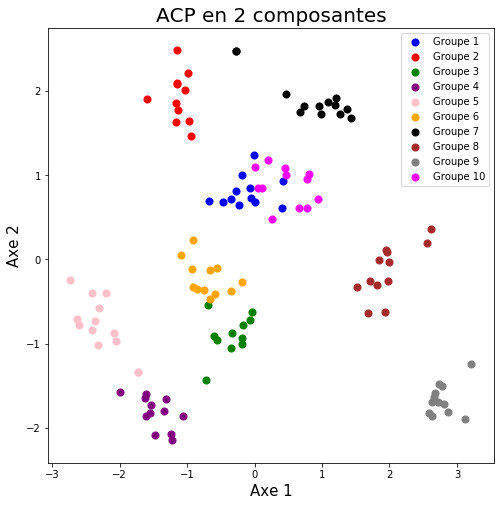

In [42]:
# Représentation simple statique 
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Axe 1', fontsize = 15)
ax.set_ylabel('Axe 2', fontsize = 15)
ax.set_title('ACP en 2 composantes', fontsize = 20)
#targets = list(set(df_res['label']))
targets = ['Groupe 1', 'Groupe 2', 'Groupe 3', 'Groupe 4', 'Groupe 5', 'Groupe 6', 'Groupe 7', 'Groupe 8', 'Groupe 9', 'Groupe 10']
colors = ['blue', 'red', 'green', 'purple', 'pink', 'orange', 'black', 'brown', 'grey', 'magenta']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'Axe 1']
               , finalDf.loc[indicesToKeep, 'Axe 2']
               , c = color
               , s = 50)
ax.legend(targets)
plt.savefig('acp_fict.png')

In [45]:
finalDf

,Axe 1,Axe 2,label,mot
0,2.987176,0.031446,Couple 1,homme
1,2.709170,-0.184522,Couple 1,femme
2,0.206766,-2.748789,Couple 2,chien
3,0.372776,-2.755121,Couple 2,chat
4,1.215330,-1.067427,Couple 3,vanille
5,1.624615,-1.106978,Couple 3,chocolat
6,-2.096077,0.217407,Couple 4,poli
7,-1.716385,0.479379,Couple 4,courtois
8,-0.010375,0.126049,Couple 5,choqué
9,0.141995,-0.002786,Couple 5,horrifié


In [29]:
# Représentation interactive 

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#Travailler avec sous-table sinon trop lourd
subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)


subFinalDf.iplot(kind='scatter',
              mode='markers',
              x='Axe 1',
              y='Axe 2',
              categories='label',
              text='mot',
              xTitle='Axe 1',
              yTitle='Axe 2',
              title='ACP en 2 composantes',
              filename='cufflinks/simple-scatter')

### T-SNE

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd

liste2 = ["homme","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence",                  
"chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami",
"vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence",
"poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander",
"choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah",
"propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant",
"canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid",
"téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues",
"voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager",
"grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"
]

df_res2 = pd.DataFrame.from_dict(mot_poids).transpose()
df_res2 = df_res2.loc[liste2]

df_res2['label'] = 'Autre' 

df_res2.loc[
    ["homme","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
    'label'] = "Groupe 1"
df_res2.loc[
    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
    'label'] = "Groupe 2"
df_res2.loc[
    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
    'label'] = "Groupe 3"
df_res2.loc[
    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
    'label'] = "Groupe 4"
df_res2.loc[
    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
    'label'] = "Groupe 5"
df_res2.loc[
    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
    'label'] = "Groupe 6"
df_res2.loc[
    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
    'label'] = "Groupe 7"
df_res2.loc[
    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
    'label'] = "Groupe 8"
df_res2.loc[
    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
    'label'] = "Groupe 9"
df_res2.loc[
    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"],
    'label'] = "Groupe 10"

from sklearn.preprocessing import StandardScaler
features = [0, 1, 2, 3, 4, 5, 6, 7,8,9]
# Separating out the features
data_x = df_res2.loc[:, features].values
# Separating out the target
data_y = df_res2.loc[:,['label']].values

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(data_x)

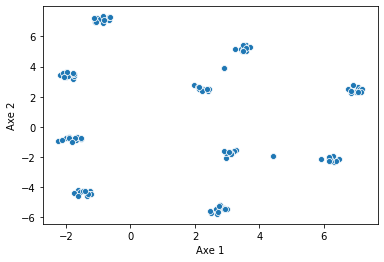

In [31]:
test_features =["Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1","Groupe 1",
                 "Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2","Groupe 2",
                 "Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3","Groupe 3",
                 "Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4","Groupe 4",
                 "Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5","Groupe 5",
                 "Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6","Groupe 6",
                 "Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7","Groupe 7",
                 "Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8","Groupe 8",
                 "Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9","Groupe 9",
                 "Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10","Groupe 10"          
                ]
tsne_df = pd.DataFrame({'Axe 1':tsne_obj[:,0],
                        'Axe 2':tsne_obj[:,1],
                       'label':test_features})
sns.scatterplot(x="Axe 1", y="Axe 2",
              data=tsne_df)

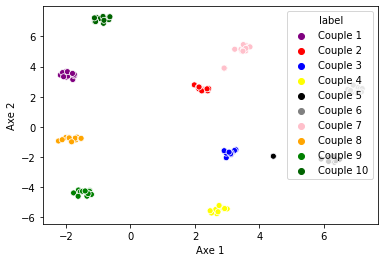

In [32]:
sns.scatterplot(x="Axe 1", y="Axe 2",
              hue="label",
              palette=['purple','red',"blue","yellow","black","gray","pink","orange","green","darkgreen"],
              legend='full',
              data=tsne_df);

In [33]:
tsne_df

,Axe 1,Axe 2,label
0,-2.004630,3.662395,Couple 1
1,-1.790817,3.143513,Couple 1
2,-1.988260,3.298735,Couple 1
3,-1.739879,3.389087,Couple 1
4,-2.175716,3.438566,Couple 1
5,-1.945763,3.367712,Couple 1
6,-1.791919,3.536638,Couple 1
7,-2.107087,3.600502,Couple 1
8,-1.744830,3.485282,Couple 1
9,-1.956082,3.662929,Couple 1


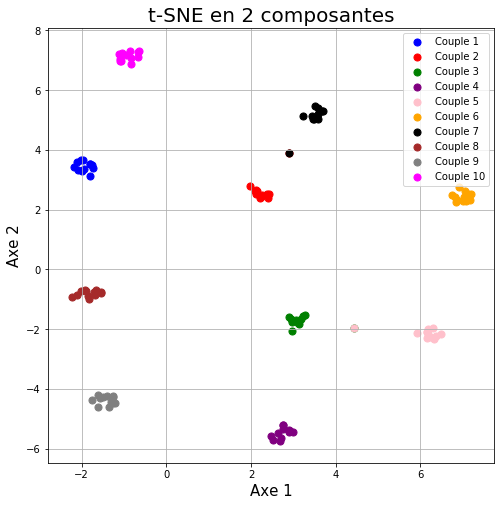

In [34]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Axe 1', fontsize = 15)
ax.set_ylabel('Axe 2', fontsize = 15)
ax.set_title('t-SNE en 2 composantes', fontsize = 20)
#targets = list(set(df_res['label']))
targets = ['Couple 1', 'Couple 2', 'Couple 3', 'Couple 4', 'Couple 5', 'Couple 6', 'Couple 7', 'Couple 8', 'Couple 9', 'Couple 10']
colors = ['blue', 'red', 'green', 'purple', 'pink', 'orange', 'black', 'brown', 'grey', 'magenta']
for target, color in zip(targets,colors):
    indicesToKeep = tsne_df['label'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 'Axe 1']
               , tsne_df.loc[indicesToKeep, 'Axe 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('tsne_fict.png')